# The Rayleigh integral

Shahar Shani-Kadmiel$^{1,2,∗}$, Gil Averbuch$^{1,2}$, Pieter Smets$^{1,2}$, Jelle Assink$^{2}$, Läslo Evers$^{2,1}$

$^1$ Faculty of Civil Engineering and Geosciences, Department of Geoscience and Engineering, Delft University of Technology, Delft, The Netherlands.

$^2$ R&D Seismology and Acoustics, Royal Netherlands Meteorological Institute (KNMI), De Bilt, The Netherlands.


## Theory in brief

The atmospheric acoustic perturbation from a permanent vertical displacement of the ground-atmosphere interface is simulated using the Rayleigh integral. As a special case of the *Kirchhoff-Helmholtz integral*, the *Rayleigh integral* calculates the radiated acoustic pressure field from a planar vibration source in a fluid half-space. Considering a closed volume free of sources, the Rayleigh integral states that if the acoustic pressure or velocity is determined along the boundary of the volume, the pressure in any point within it can be determined.

The radiated acoustic pressure field, $p(\pmb{r},\omega)$, from a planar vibrating source positioned at $\pmb{r}_0 = (x_0,y_0,z_0)$ and recorded by a
receiver positioned at at $\pmb{r} = (x,y,z)$ in a homogeneous fluid
half-space is given by the Rayleigh integral ([Wapenaar & Berkhout, 1989](#1); [Green et al., 2009](#2)):

\begin{equation}
p(\pmb{r},\omega) = \frac{i k \rho c}{2 \pi} \int_{S_0} \frac{e^{-i k |\pmb{r} - \pmb{r}_0|}}{|\pmb{r} - \pmb{r}_0|} v(\pmb{r}_0, \omega) dS_0,
\end{equation}
where $\omega$ is angular frequency, $k$ is the medium wavenumber, $v(\pmb{r}_0, \omega)$ is the complex spectral component of the surface vertical velocity, and the kernel, $\exp(-i k |\pmb{r} - \pmb{r}_0|)/|\pmb{r} - \pmb{r}_0|$, is the Green's function for a homogeneous medium.

In this study we use a Gaussian pulse STF
\begin{equation}
v(\pmb{r}_0, t) = \frac{\omega_0}{\sqrt{2 \pi}} e^{-\omega_0^2 (t - t_0)^2 / 2},
\end{equation}
with a central frequency $\omega_0$ = 0.1 Hz to drive the piston velocity, which when integrated, describes the permanent displacement of the piston (see Section 2 of the Supplementary material). Using the Fourier transform, the spectral components of the STF are represented as:
\begin{equation}
v(\pmb{r}_0, \omega) = \int_{-\infty}^{\infty} v(\pmb{r}_0, t) e^{-i \omega t} dt,
\end{equation}
and the waveforms at the receiver are obtained by the inverse transform
\begin{equation}
p(\pmb{r},t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} p(\pmb{r},\omega) e^{i \omega t} d\omega.
\end{equation}

### References

1. Wapenaar, C., & Berkhout, A. (Eds.) (1989). [*Elastic Wave Field Extrapolation*](https://www.sciencedirect.com/bookseries/advances-in-exploration-geophysics/vol/2/suppl/C) volume 2. Elsevier.

2. Green, D. N., Guilbert, J., Le Pichon, A., Sebe, O., & Bowers, D. (2009). Modelling ground-to-air coupling for the shallow ML 4.3 Folkestone, United Kingdom, earthquake of 28 april 2007. *Bull. Seismol. Soc. Am.*, 99, 2541–2551. doi:[10.1785/0120080236](http://dx.doi.org/10.1785/0120080236).


## Solving the Rayleigh integral for one source-receiver pair

### Imports and function definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

_2pi = 2 * np.pi

In [2]:
def gaussian_stf(t, t0, freq):
    """
    Gaussian pulse STF.
    
    Parameters
    ----------
    t : array-like
        Time vector in seconds at the desired samples-per-second. This
        should be long enough to fit the propagation time from the
        source to the receiver with some extra and is most efficient
        when the number of samples is a power of 2.
        
    t0 : float
        Time of peak amplitude.
    
    freq : float
        Central frequency.
        
    Returns
    -------
    v : array-like, same shape as ``t``
        The STF
    """
    omega = _2pi * freq
    v = (
        (omega / np.sqrt(_2pi)) *
        np.exp(-0.5 * (omega**2) * (t - t0)**2)
    )
    return v


def rayleigh_integral(stf, dt, rho, c, r, dx, dy=None, r0=(0, 0, 0)):
    """
    Compute the Rayleigh integral.
    
    Parameters
    ----------
    stf : array-like
        The source-time-function describing the vertical velocity of the
        source.
        
    dt : float
        The time delta between samples in the ``stf``.
        
    rho : float
        The density of the source in kg/m^3.
        
    c : float
        Propagation velocity of the medium in m/s.
        
    r : tuple
        (x, y, z) coordinates of the reciever.
        
    dx, dy : float
        The horizontal dimentions of the source. Default is ``dy=dx``.
        
    r0 : tuple
        (x, y, z) coordinates of the source.
    """
    dy = dy or dx
    
    x0, y0, z0 = r0
    x, y, z = r
    R = np.sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2)
    
    n = len(stf)
    S_amp = np.fft.fft(stf)
    S_freq = np.fft.fftfreq(n, dt)
    
    k = _2pi * S_freq / c
    
    p = (
        (1j * k * dx * dy * rho * c) / _2pi *
        np.exp(-1j * k * R) / R * S_amp
    )
    
    return np.fft.ifft(p).real

### Source-Receiver pair

Text(0, 0.5, 'y, m')

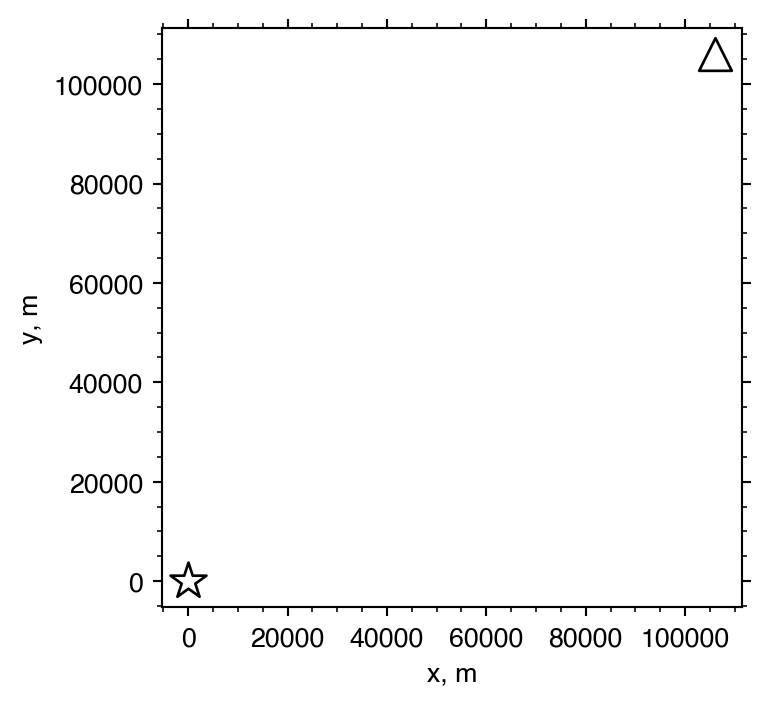

In [3]:
# distance and bearing
az = 45  # degrees CW from N
R = 150e3  # m

# coordinates
r0 = (0, 0, 0)
r = (R * np.cos(np.radians(az)), R * np.sin(np.radians(az)), 0)

# propagation velocity:
c = 330  # m/s

# travel-time
tt = R / c

fig, ax = plt.subplots()
ax.scatter(*r0[:2], s=200, marker='*', c='w', ec='k')
ax.scatter(*r[:2], s=150, marker='^', c='w', ec='k')
ax.set_aspect(1)
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')

### The Gaussian pulse STF

Text(0.5, 0, 'Frequncy, Hz')

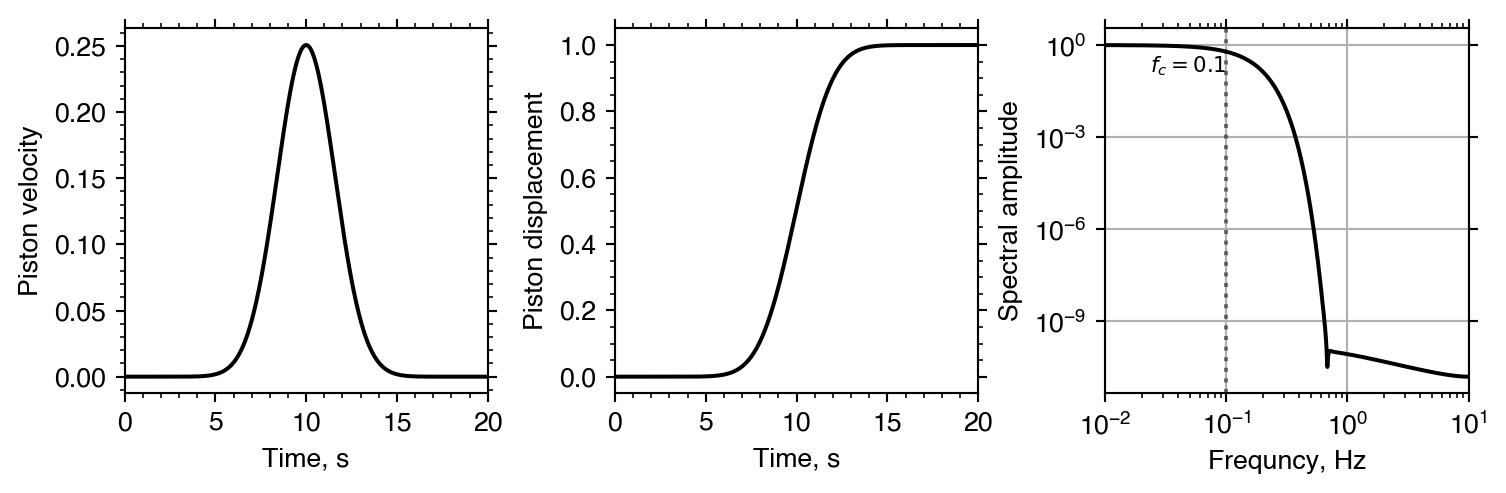

In [4]:
dt = 0.05 # 20 Hz sampling rate

# next power of 2
npts = int(np.power(2, np.ceil(np.log2(tt / dt))))

t = np.arange(0, npts * dt, dt)

t0 = 10
stf = gaussian_stf(t, t0, freq=0.1) 

s_freq = np.fft.rfftfreq(stf.size, dt)
s_amp = np.fft.rfft(stf)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(7, 1.9))
fig.subplots_adjust(0, 0, 1, 1, wspace=0.35)
ax1.plot(t, stf, 'k')
ax1.set_xlim(0, 20)
# ax1.set_yticklabels([])
ax1.set_ylabel('Piston velocity')
ax1.set_xlabel('Time, s')

ax2.plot(t, stf.cumsum() * dt, 'k')
ax2.set_xlim(0, 20)
# ax2.set_yticklabels([])

ax2.set_ylabel('Piston displacement')
ax2.set_xlabel('Time, s')

ax3.loglog(s_freq, np.abs(s_amp * dt), 'k')
ax3.grid(True)
# ax3.set_yticklabels([])
ax3.set_xlim(1e-2, 10)
ax3.axvline(0.1, c='k', ls=':', alpha=0.5)
ax3.text(0.1, 0.5, '$f_c=0.1$', size=8, va='top', ha='right')
ax3.set_ylabel('Spectral amplitude')
ax3.set_xlabel('Frequncy, Hz')


### The acoustic pressure signal at the receiver

Text(0, 0.5, 'Pressure, Pa')

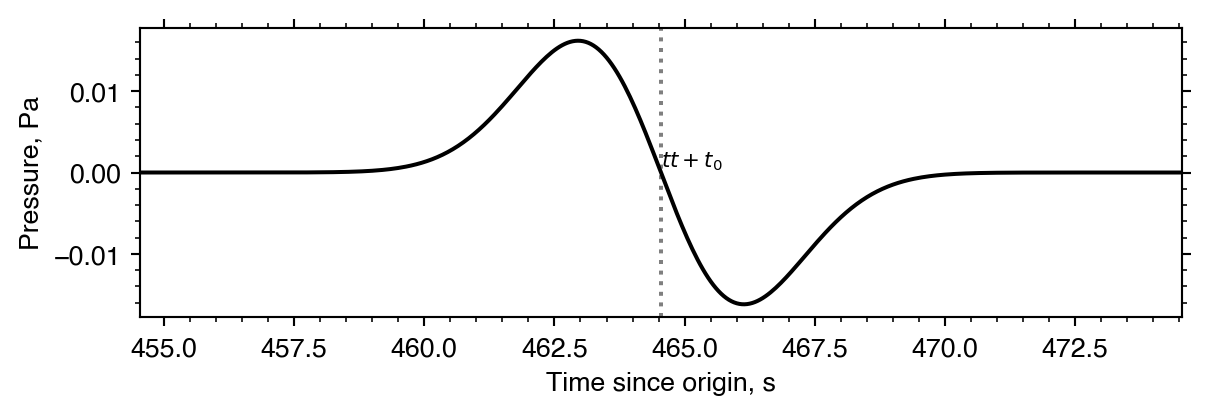

In [5]:
p = rayleigh_integral(stf, dt, 1, c, r, dx=400)

fig, ax = plt.subplots(figsize=(7,2))
ax.plot(t, p, 'k')
ax.set_xlim(tt, tt + 20)
ax.axvline(tt + 10, c='k', ls=':', alpha=0.5)
ax.text(tt + t0, 0, '$tt + t_0$', size=8, va='bottom', ha='left')
ax.set_xlabel('Time since origin, s')
ax.set_ylabel('Pressure, Pa')